In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from SLoader import SLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


0.007248534355312586 0.0012473572278395295


/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x[0]).unsqueeze(1)
/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y[0]).unsqueeze(1)
/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_std = torch.tensor(x_std[0]).unsqueeze(1)
/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:53: UserWarning: To copy constr

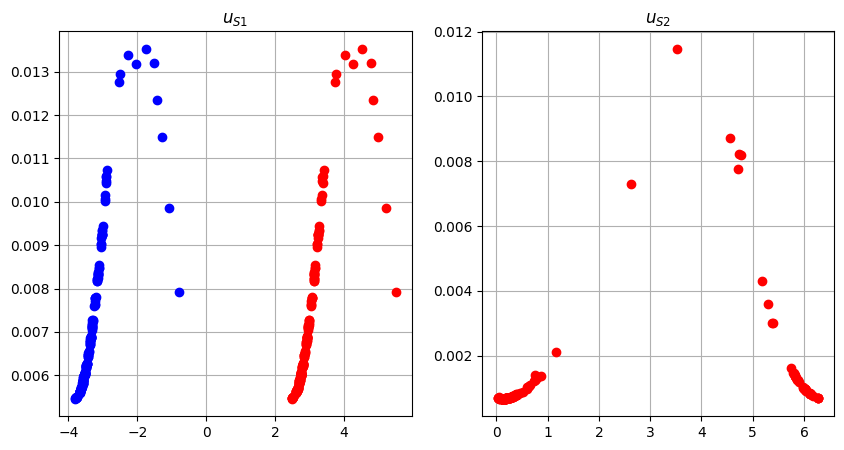

In [ ]:
S1_scaling = 6e-5

S1 = SLoader(files=["data/S1_astrometry_data.csv"], scaling=S1_scaling)
S2 = SLoader(files=["data/astrometry_NACO.csv", "data/astrometry_SHARP.csv"])

scaling1 = torch.mean(S1.u).item() 
scaling2 = torch.mean(S2.u).item()
print(scaling1, scaling2)

S1_scaling = scaling1/scaling2

S1 = SLoader(files=["data/S1_astrometry_data.csv"], scaling=S1_scaling)


#S1 = SLoader(files=["data/S1_astrometry_data.csv"], scaling=scaling1, std_data=True)
#S2 = SLoader(files=["data/astrometry_NACO.csv", "data/astrometry_SHARP.csv"], scaling=scaling2, std_data=True)

u1 = S1.u
u2 = S2.u
phi1 = S1.phi
phi2 = S2.phi

phi = torch.linspace(0, 2*torch.pi, steps=1000).view(-1,1)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].grid()
ax[0].set_title(r"$u_{S1}$")
ax[0].plot(phi1, u1, 'ro')

ax[0].plot(phi1-2*torch.pi, u1, 'bo');


ax[1].grid()
ax[1].set_title(r"$u_{S2}$")
ax[1].plot(phi2, u2, 'ro');



In [30]:
import torch
import torch.nn as nn

def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True)



class NNBlock(nn.Module):
    """
    Standard Feed Forward Neural Network 
    """
    def __init__(self, in_chan, out_chan, chans=[5,10,5], dropout_prob=0.1):
        super().__init__()
        #self.in_block = nn.Linear(in_chan, chans[0])
        layers = []

        layers.append(nn.Linear(in_chan, chans[0]))
        layers.append(nn.Tanh())
        #layers.append(nn.Dropout(p=dropout_prob))
        for i in range(len(chans) - 1):
            layers.append(nn.Linear(chans[i], chans[i+1]))
            layers.append(nn.Tanh())
            #layers.append(nn.Dropout(p=dropout_prob))

        layers.append(nn.Linear(chans[-1], out_chan))
        self.blocks = nn.Sequential(*layers)

    def forward(self, x):
        return self.blocks(x)


class PINN(nn.Module):
    def __init__(self, in_chan=1, out_chan=1, chans=[5,10,5], 
                e_ini=None, mu_ini=None, norm=1.):
        super().__init__()

        # Predicts Chi
        self.nn = NNBlock(in_chan, out_chan, chans=chans)

        self.norm = norm

        if e_ini == None:   
            self.e_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        else:
            self.e_ = torch.nn.Parameter(torch.tensor(e_ini))
        
        if mu_ini == None:
            self.mu_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        else:
            self.mu_ = torch.nn.Parameter(torch.tensor(mu_ini))
 
        # Enable gradient for trainable parameters
        self.e_requires_grad = True
        self.mu_.requires_grad = True
 
    def forward(self, x, M):
        # Output u
        mu = self.get_mu()#.item()
        e  = self.get_e()#.item()

        u = mu/M * (1 + e*torch.cos(self.nn(x)))
        return u
    
    def get_e(self):
        #return torch.abs(self.e_)
        return torch.tanh(torch.abs(self.e_))
    
    def get_mu(self):
        #return torch.abs(self.mu_)
        return self.mu_ * self.norm
    
    def physical_loss(self, phi, lambda1=1., lambda2=1.):
        chi = self.nn(phi)

        mu = self.get_mu()#.item()
        e  = self.get_e()#.item()

        dchi = grad(chi, phi)[0]
        ddchi = grad(dchi, phi)[0]

        ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi)))
        ode2 = ddchi - mu*e*torch.sin(chi)

        loss1 = torch.mean(ode1**2)
        loss2 = torch.mean(ode2**2)
        #loss1 = torch.mean(torch.abs(ode1))
        #loss2 = torch.mean(torch.abs(ode2))

        loss1 *= lambda1
        loss2 *= lambda2
        return loss1, loss2
    


class SPINN(nn.Module):
    def __init__(self, in_chan=1, out_chan=1, chans=[5,10,5],
                norm1=1., norm2=1.):
        super().__init__()
        self.M_ = torch.nn.Parameter(torch.tensor(0.042))
        self.M_.requires_grad = True

        # mu_ini = 1.4e-4
        self.S1 = PINN(in_chan, out_chan, chans, e_ini=0.425, mu_ini=6., norm=norm1)
        self.S2 = PINN(in_chan, out_chan, chans, e_ini=0.88, mu_ini=1.8e-4, norm=norm2)

        self.norm1 = 1.
        self.norm2 = 1.
    
    def set_norm(self, norm1, norm2):
        self.norm1 = norm1
        self.norm2 = norm2

    def get_M(self):
        return torch.abs(self.M_)
    
    def forward(self, x1, x2):
        y1 = self.S1(x1, self.get_M())
        y2 = self.S2(x2, self.get_M())

        return y1, y2
    
    def physical_loss(self, phi):
        phi = torch.linspace(-2.1*torch.pi, 4.2*torch.pi, steps=1000).view(-1,1).requires_grad_(True)
        loss1_1, loss1_2 = self.S1.physical_loss(phi, lambda1=1., lambda2=1.)
        phi = torch.linspace(-2.1*torch.pi, 4.2*torch.pi, steps=1000).view(-1,1).requires_grad_(True)
        loss2_1, loss2_2 = self.S2.physical_loss(phi, lambda1=1., lambda2=1.)

        return loss1_1, loss1_2, loss2_1, loss2_2



In [31]:
# Initialize model
lr = 1e-4

model = SPINN(1, 1, chans=[8,16,16,8], norm1=S1_scaling).to(device) # 8, 16, 16, 8
print(model.S1.get_mu())
print(model.S2.get_mu())
#model.set_norm(scaling1, scaling2)
#optimizer = optim.SGD(lr=lr, params=model.parameters())
#optimizer = optim.Adagrad(lr=lr, params=model.parameters())
optimizer = optim.Adam(lr=lr, params=model.parameters())
"""
optimizer = optim.Adam([{'params': model.S1.nn.parameters(), 'lr': 1e-3},
                       {'params': model.S2.nn.parameters(), 'lr': 1e-3},
                       {'params': model.S2.e_, 'lr': 1e-3},
                       {'params': model.S2.mu_, 'lr': 1e-5},
                       {'params': model.S1.e_, 'lr': 1e-3}, 
                       {'params': model.S1.mu_, 'lr': 1e-5},
                       {'params': model.M_, 'lr': 1e-6}])
"""
#criterion = nn.MSELoss()
criterion = nn.L1Loss()

losses1 = [[], [], [], []]
losses2 = [[], [], [], []]
params1 = [[], []]
params2 = [[], []]
params3 = []

phi_lin = torch.linspace(-2.1*torch.pi, 4.2*torch.pi, steps=1000).view(-1,1).requires_grad_(True)
phi_lin = phi_lin.to(device)

phys_loss_weight = 0.
#phys_loss_weight = 1e4

phys_loss_weight1 = 1e2
phys_loss_weight2 = 1e2
data_loss_weight1 = 1.
data_loss_weight2 = 1.


alpha = 0.9

w_mse1_old = 1.
w_mse2_old = 1.
w_phys1_1_old = 1.
w_phys2_1_old = 1.
w_phys1_2_old = 1.
w_phys2_2_old = 1.

tensor(0.0004, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<MulBackward0>)


In [32]:
epochs = 10_000


# For rel.diff. loss use phys_loss_weight = 1e0

for epoch in tqdm(range(epochs)):
    phi1, u1 = S1()
    phi2, u2 = S2()
    
    phi1 = phi1.to(device); phi2 = phi2.to(device)
    u1 = u1.to(device); u2 = u2.to(device)
    
    out1, out2 = model(phi1, phi2)

    MSEloss1 = criterion(out1, u1)
    MSEloss2 = criterion(out2, u2)

    #MSEloss1 = criterion(1/out1, 1/u1)
    #MSEloss2 = criterion(1/out2, 1/u2)
    #MSEloss = criterion(torch.log(out + 1e-8), torch.log(u + 1e-8))    # Minimize relative difference
    #MSEloss = torch.mean(torch.abs(out - u)**2 / (torch.abs(u) + 1e-8))    # Minimize MSE weightet by r

    #PHYSloss1, PHYSloss2 = model.physical_loss(phi_lin)
    PHYSloss1_1, PHYSloss1_2 = model.S1.physical_loss(phi_lin, lambda1=1., lambda2=1.)
    PHYSloss2_1, PHYSloss2_2 = model.S2.physical_loss(phi_lin, lambda1=1., lambda2=1.)

    #w_mse1 = ((MSEloss1 + MSEloss2 + PHYSloss1 + PHYSloss2)/MSEloss1).item()
    #w_mse2 = ((MSEloss1 + MSEloss2 + PHYSloss1 + PHYSloss2)/MSEloss2).item()
    #w_phys1 = ((MSEloss1 + MSEloss2 + PHYSloss1 + PHYSloss2)/PHYSloss1).item()
    #w_phys2 = ((MSEloss1 + MSEloss2 + PHYSloss1 + PHYSloss2)/PHYSloss2).item()

    w_mse1 = ((MSEloss1 + PHYSloss1_1 + PHYSloss1_2)/MSEloss1).item()
    w_mse2 = ((MSEloss2 + PHYSloss2_1 + PHYSloss2_2)/MSEloss2).item()

    w_phys1_1 = ((MSEloss1 + PHYSloss1_1 + PHYSloss1_2)/PHYSloss1_1).item()
    w_phys1_2 = ((MSEloss1 + PHYSloss1_1 + PHYSloss1_2)/PHYSloss1_2).item()

    w_phys2_1 = ((MSEloss2 + PHYSloss2_1 + PHYSloss2_2)/PHYSloss2_1).item()
    w_phys2_2 = ((MSEloss2 + PHYSloss2_1 + PHYSloss2_2)/PHYSloss2_2).item()

    w_mse1 = alpha * w_mse1_old + (1 - alpha) * w_mse1
    w_mse2 = alpha * w_mse2_old + (1 - alpha) * w_mse2
    w_phys1_1 = alpha * w_phys1_1_old + (1 - alpha) * w_phys1_1
    w_phys1_2 = alpha * w_phys1_2_old + (1 - alpha) * w_phys1_2
    w_phys2_1 = alpha * w_phys2_1_old + (1 - alpha) * w_phys2_1
    w_phys2_2 = alpha * w_phys2_2_old + (1 - alpha) * w_phys2_2

    MSEloss1 *= w_mse1
    MSEloss2 *= w_mse2
    PHYSloss1_1 *= w_phys1_1
    PHYSloss1_2 *= w_phys1_2
    PHYSloss2_1 *= w_phys2_1
    PHYSloss2_2 *= w_phys2_2
    


    loss1 = MSEloss1 + PHYSloss1_1 + PHYSloss1_2
    loss2 = MSEloss2 + PHYSloss2_1 + PHYSloss2_2

    loss = loss1 + loss2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses1[0].append(loss1.cpu().detach().numpy())
    losses1[1].append(MSEloss1.cpu().detach().numpy())
    losses1[2].append(PHYSloss1_1.cpu().detach().numpy())
    losses1[3].append(PHYSloss1_2.cpu().detach().numpy())

    losses2[0].append(loss2.cpu().detach().numpy())
    losses2[1].append(MSEloss2.cpu().detach().numpy())
    losses2[2].append(PHYSloss2_1.cpu().detach().numpy())
    losses2[3].append(PHYSloss2_2.cpu().detach().numpy())

    params1[0].append(model.S1.get_e().item())
    params1[1].append(model.S1.get_mu().item())

    params2[0].append(model.S2.get_e().item())
    params2[1].append(model.S2.get_mu().item())

    params3.append(model.get_M().item())

    w_mse1_old = w_mse1
    w_mse2_old = w_mse2
    w_phys1_1_old = w_phys1_1
    w_phys1_2_old = w_phys1_2
    w_phys2_1_old = w_phys2_1
    w_phys2_2_old = w_phys2_2

  0%|          | 0/10000 [00:00<?, ?it/s]/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(phi, dtype=torch.float32), torch.tensor(u, dtype=torch.float32) # norm const
100%|██████████| 10000/10000 [02:56<00:00, 56.64it/s]


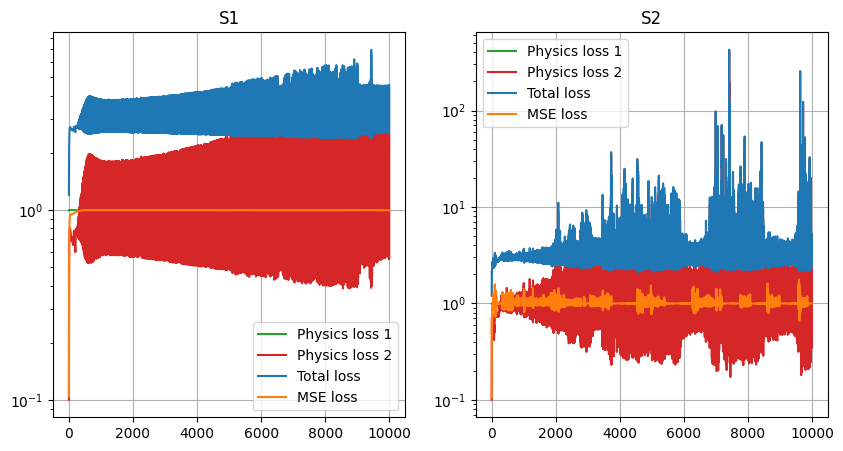

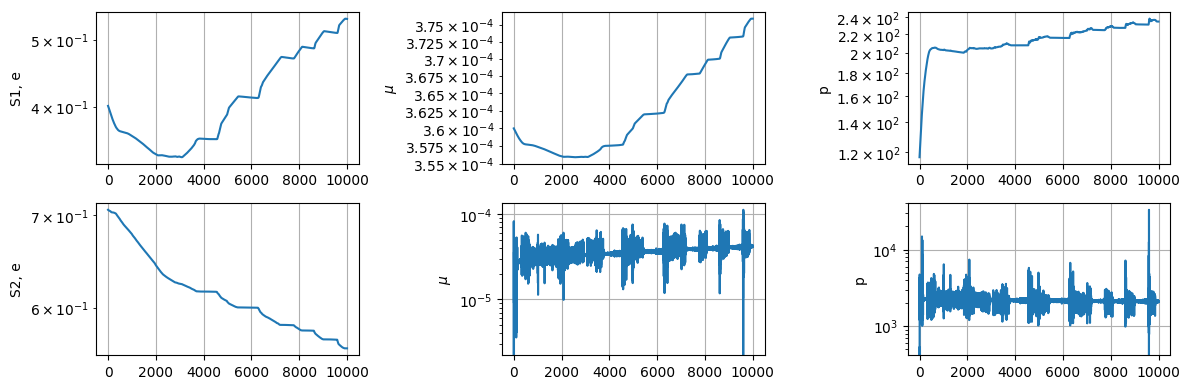

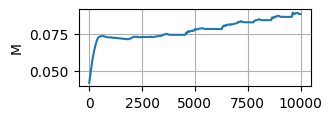

In [33]:

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].set_title("S1")
ax[0].plot(losses1[2], label="Physics loss 1", c="tab:green")
ax[0].plot(losses1[3], label="Physics loss 2", c="tab:red")
ax[0].plot(losses1[0], label="Total loss", c="tab:blue")
ax[0].plot(losses1[1], label="MSE loss", c="tab:orange")

ax[1].set_title("S2")
ax[1].plot(losses2[2], label="Physics loss 1", c="tab:green")
ax[1].plot(losses2[3], label="Physics loss 2", c="tab:red")
ax[1].plot(losses2[0], label="Total loss", c="tab:blue")
ax[1].plot(losses2[1], label="MSE loss", c="tab:orange")

[[axi.grid(), axi.legend(), axi.set_yscale("log")] for axi in ax]
plt.show()


fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12,4))
[[[axij.set_yscale("log")] for axij in axi] for axi in ax] # set all yscale to log

ax[0,0].plot(params1[0])
ax[0,0].set_ylabel("S1, e")
ax[0,0].grid()

ax[0,1].plot(params1[1])
ax[0,1].set_ylabel(r"$\mu$")
ax[0,1].grid()

ax[0,2].plot(np.array(params3)/np.array(params1[1]))
ax[0,2].set_ylabel("p")
ax[0,2].grid()

ax[1,0].plot(params2[0])
ax[1,0].set_ylabel("S2, e")
ax[1,0].grid()

ax[1,1].plot(params2[1])
ax[1,1].set_ylabel(r"$\mu$")
ax[1,1].grid()

ax[1,2].plot(np.array(params3)/np.array(params2[1]))
ax[1,2].set_ylabel("p")
ax[1,2].grid()

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(3,1))
ax.set_ylabel("M")
ax.plot(params3)
ax.grid()

In [34]:

print("\n===== S1 =====")
print("e =", model.S1.get_e().item())
print("p =", model.get_M().item()/model.S1.get_mu().item()*model.norm1)
#print("p =", model.S2.get_p().item())
print("mu =", model.S1.get_mu().item())

print("\n===== S2 =====")
print("e =", model.S2.get_e().item())
print("p =", model.get_M().item()/model.S2.get_mu().item()*model.norm2)
#print("p =", model.S2.get_p().item())
print("mu =", model.S2.get_mu().item())

print("\nM =", model.get_M().item())


#M_md = torch.mean(1 - torch.abs(model(S1.phi.to(device)).cpu() - S1.u)/S1.u).item()
#print("M-model-data =", M_md)


# S2
# e  ~ 0.884 (0.884)
# p  ~ 228 (223) AU
# mu ~ 1.8e-4
# M  ~ 0.04239 AU

# M-model-data ~ 0.9755



===== S1 =====
e = 0.5360391139984131
p = 234.73894394457795
mu = 0.0003758760867640376

===== S2 =====
e = 0.5608978271484375
p = 2074.505014286515
mu = 4.253195584169589e-05

M = 0.08823275566101074


0.0
tensor(0.9947, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.9034e-12, device='cuda:0', grad_fn=<MeanBackward0>)


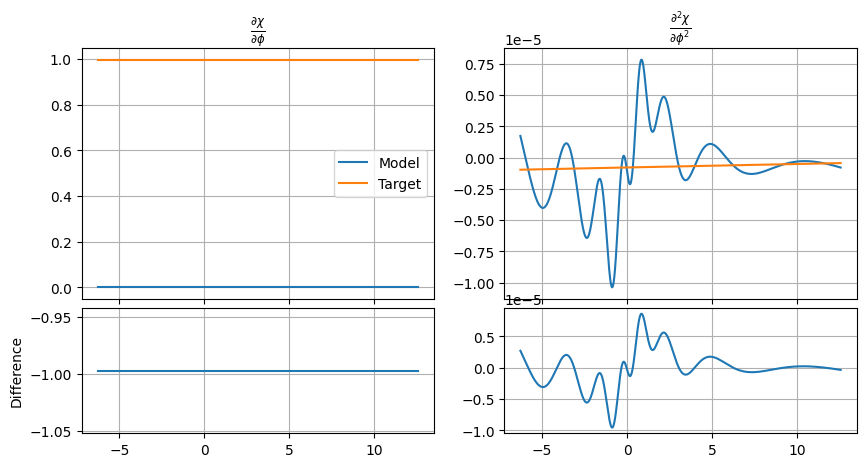

0.0
tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.3442e-12, device='cuda:0', grad_fn=<MeanBackward0>)


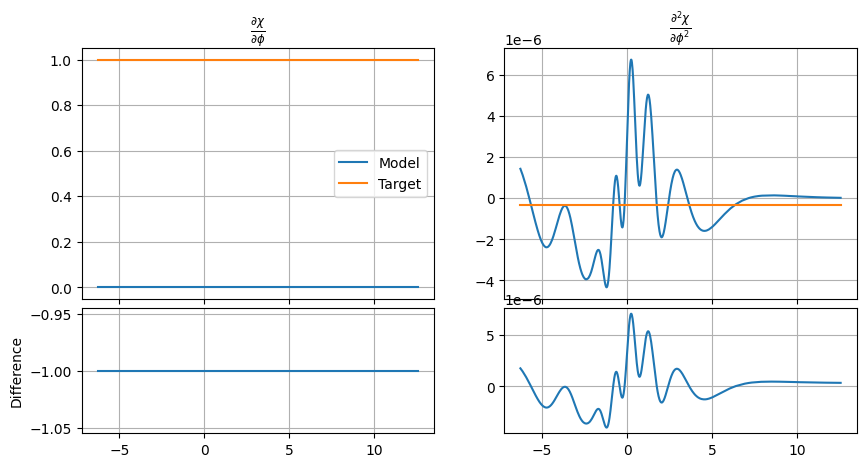

In [35]:
def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True)

_phi = torch.linspace(-2*torch.pi, 4*torch.pi, steps=1000).view(-1,1).requires_grad_(True).to(device)
chi = model.S1.nn(_phi)

mu = model.S1.get_mu().item()
#p  = self.get_p()
#M  = self.get_M()
e  = model.S1.get_e().item()

dchi = grad(chi, _phi)[0]
ddchi = grad(dchi, _phi)[0]

ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi)))
ode2 = ddchi - mu*e*torch.sin(chi)

print(phys_loss_weight)
print(torch.mean(ode1**2))
print(torch.mean(ode2**2))

_phi = _phi.cpu().detach().numpy()
dchi = dchi.cpu().detach().numpy()
ddchi = ddchi.cpu().detach().numpy()
chi = chi.cpu().detach()
ode1 = ode1.cpu().detach().numpy()
ode2 = ode2.cpu().detach().numpy()

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,5), gridspec_kw={'height_ratios':[2,1]}, sharex=True)
ax[0,0].grid()
ax[0,0].set_title(r"$\frac{\partial \chi}{\partial \phi}$")
ax[0,0].plot(_phi, dchi**2, label="Model")
ax[0,0].plot(_phi, (1 - 2*mu*(3 + e*torch.cos(chi))), label="Target")
ax[0,0].legend()

ax[0,1].grid()
ax[0,1].set_title(r"$\frac{\partial^2 \chi}{\partial \phi^2}$")
ax[0,1].plot(_phi, ddchi)
ax[0,1].plot(_phi, mu*e*torch.sin(chi))

ax[1,0].grid()
ax[1,0].set_ylabel("Difference")
ax[1,0].plot(_phi, ode1)

ax[1,1].grid()
ax[1,1].plot(_phi, ode2)

plt.subplots_adjust(hspace=.05)
plt.show()

_phi = torch.linspace(-2*torch.pi, 4*torch.pi, steps=1000).view(-1,1).requires_grad_(True).to(device)
chi = model.S2.nn(_phi)

mu = model.S2.get_mu().item()
#p  = self.get_p()
#M  = self.get_M()
e  = model.S2.get_e().item()

dchi = grad(chi, _phi)[0]
ddchi = grad(dchi, _phi)[0]

ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi)))
ode2 = ddchi - mu*e*torch.sin(chi)

print(phys_loss_weight)
print(torch.mean(ode1**2))
print(torch.mean(ode2**2))

_phi = _phi.cpu().detach().numpy()
dchi = dchi.cpu().detach().numpy()
ddchi = ddchi.cpu().detach().numpy()
chi = chi.cpu().detach()
ode1 = ode1.cpu().detach().numpy()
ode2 = ode2.cpu().detach().numpy()

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,5), gridspec_kw={'height_ratios':[2,1]}, sharex=True)
ax[0,0].grid()
ax[0,0].set_title(r"$\frac{\partial \chi}{\partial \phi}$")
ax[0,0].plot(_phi, dchi**2, label="Model")
ax[0,0].plot(_phi, (1 - 2*mu*(3 + e*torch.cos(chi))), label="Target")
ax[0,0].legend()

ax[0,1].grid()
ax[0,1].set_title(r"$\frac{\partial^2 \chi}{\partial \phi^2}$")
ax[0,1].plot(_phi, ddchi)
ax[0,1].plot(_phi, mu*e*torch.sin(chi))

ax[1,0].grid()
ax[1,0].set_ylabel("Difference")
ax[1,0].plot(_phi, ode1)

ax[1,1].grid()
ax[1,1].plot(_phi, ode2)

plt.subplots_adjust(hspace=.05)
plt.show()

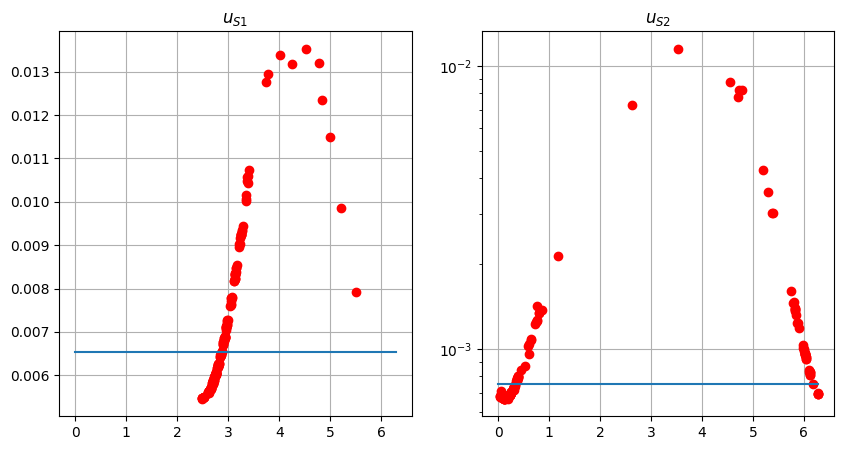

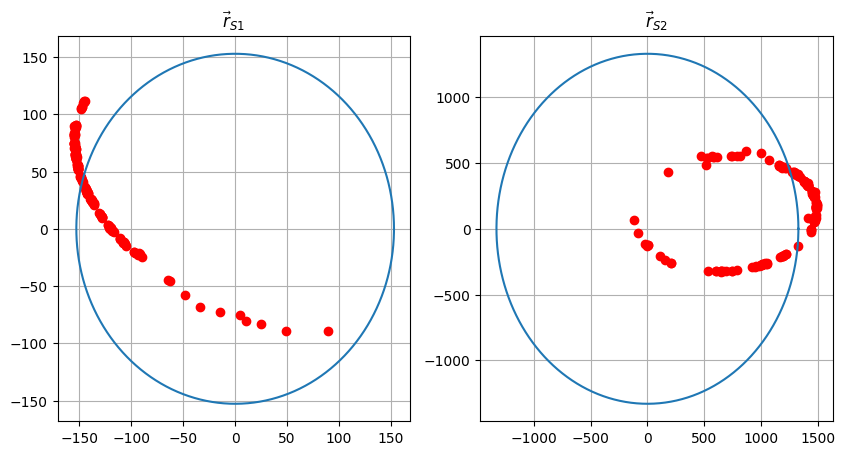

In [36]:
u1 = S1.u
u2 = S2.u
phi1 = S1.phi
phi2 = S2.phi

phi = torch.linspace(0, 2*torch.pi, steps=1000).view(-1,1).to(device)

out1 = model.S1(phi, M=model.get_M()*model.norm1).cpu().detach().numpy()
out2 = model.S2(phi, M=model.get_M()*model.norm2).cpu().detach().numpy()

phi = phi.cpu()

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].grid()
ax[0].set_title(r"$u_{S1}$")
ax[0].plot(phi1, u1, 'ro')
ax[0].plot(phi, out1)
#ax[0].set_yscale("log")

ax[1].grid()
ax[1].set_title(r"$u_{S2}$")
ax[1].plot(phi2, u2, 'ro')
ax[1].plot(phi, out2)
ax[1].set_yscale("log")



fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].grid()
ax[0].plot(torch.cos(phi1)/u1, torch.sin(phi1)/u1, 'ro')
ax[0].plot(torch.cos(phi)/out1, torch.sin(phi)/out1)
ax[0].set_title(r"$\vec{r}_{S1}$")

ax[1].grid()
ax[1].plot(torch.cos(phi2)/u2, torch.sin(phi2)/u2, 'ro')
ax[1].plot(torch.cos(phi)/out2, torch.sin(phi)/out2)
ax[1].set_title(r"$\vec{r}_{S2}$");


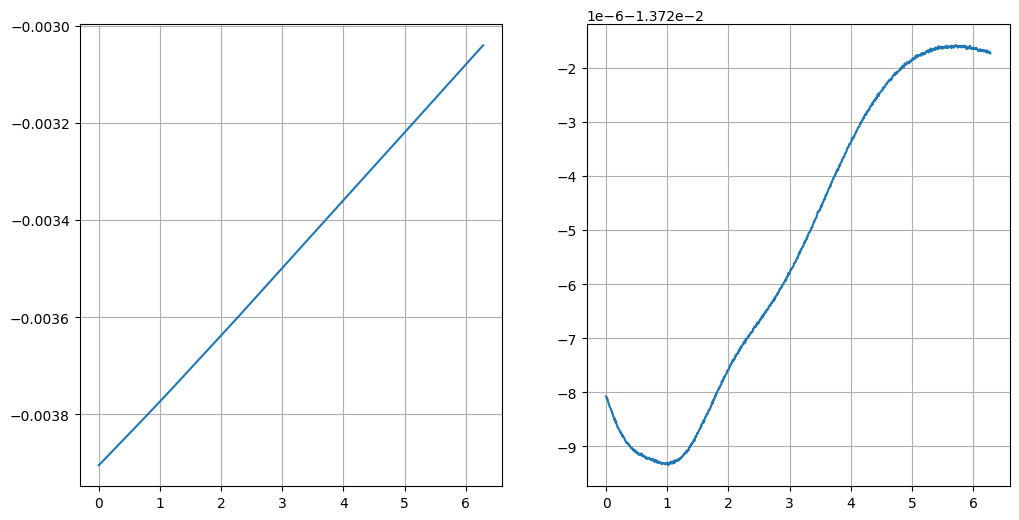

In [37]:
pphi = phi.to(device)

out1 = model.S1.nn(pphi).cpu().detach().numpy()
out2 = model.S2.nn(pphi).cpu().detach().numpy()

pphi = pphi.cpu()

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].plot(pphi, out1)
ax[0].grid()

ax[1].plot(pphi, out2)
ax[1].grid()